In [1]:
import iminuit
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal

import CohesiveCrack
import DataProcessor

In [2]:
Gamma = 0.21  # Fracture energy (J/m^2)
E = 51e9      # Young's modulus (Pa)
nu = 0.25     # Poisson's ratio
C_f = 2404    # Rupture speed (m/s)
C_s = 2760    # Shear wave speed (m/s)
C_d = 4790    # Longitudinal wave speed (m/s)

In [3]:
experiment_SN = 'p5993'

In [4]:
filename = f'../Data/{experiment_SN}e.npz'

In [5]:
data = np.load(filename, allow_pickle = True)
data = data["experiment"][()]
event = data['runs'][1]['events'][2]
exy6 = event['strain']['original']['raw'][6]


TIME_S = event['strain']['original']['time']
C_f = np.abs(event['rupture_speed'])
print(f'Cf: {C_f:.1f}m/s')

fs = len(TIME_S) / (np.max(TIME_S) - np.min(TIME_S))
print(f'Sampling rate: {fs:.1f}Hz')

DISTANCE = TIME_S * C_f * 1000 # mm


STRAIN = DataProcessor.voltage_to_strain(exy6)
STRESS = DataProcessor.shear_strain_to_stress(E, nu, STRAIN)
STRESS = STRESS - STRESS[0]
STRESS_MPA = STRESS / 10**6
STRESS_MPA *= -1

Cf: 1737.9m/s
Sampling rate: 100000.2Hz


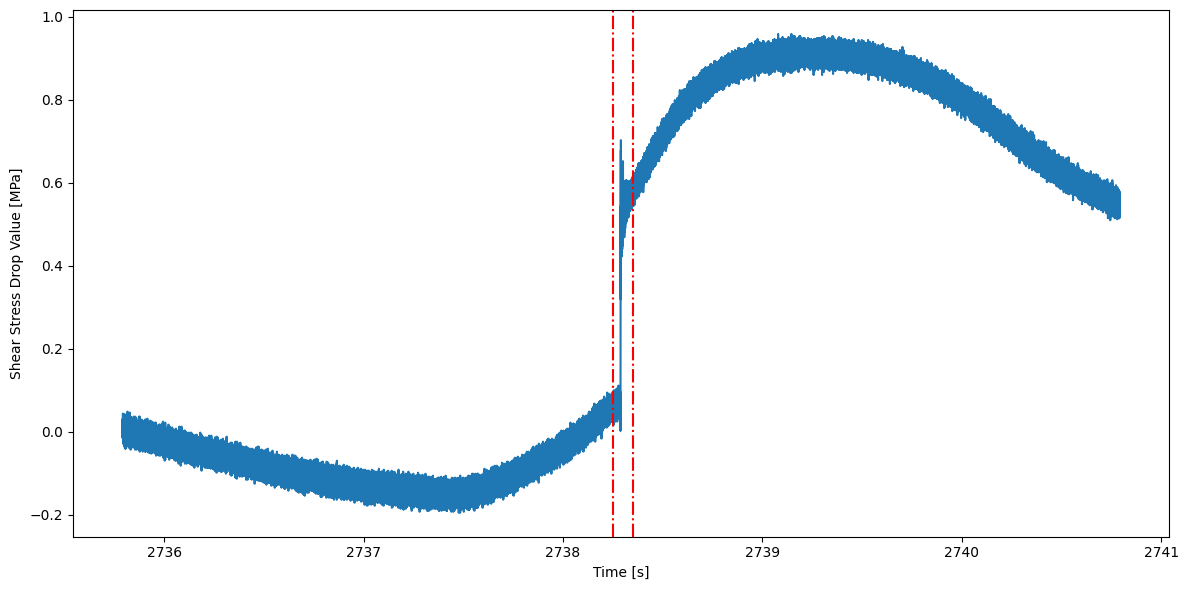

In [6]:

plt.figure(figsize = (12, 6))

plt.plot(TIME_S, STRESS_MPA, label=r'$\epsilon_{xy}$')
plt.xlabel('Time [s]')
plt.ylabel('Shear Stress Drop Value [MPa]')
plt.axvline(x = 2738.25, color = 'red', linestyle = '-.')
plt.axvline(x = 2738.35, color = 'red', linestyle = '-.')
plt.tight_layout()
plt.savefig(f'../Plot/STA-LTA-demo-1.pdf', dpi = 300)
plt.show()
plt.close()

In [7]:
cutoff = 100
FILTERED_STRESS_MPA = DataProcessor.highpass_filter(STRESS_MPA, cutoff, fs)

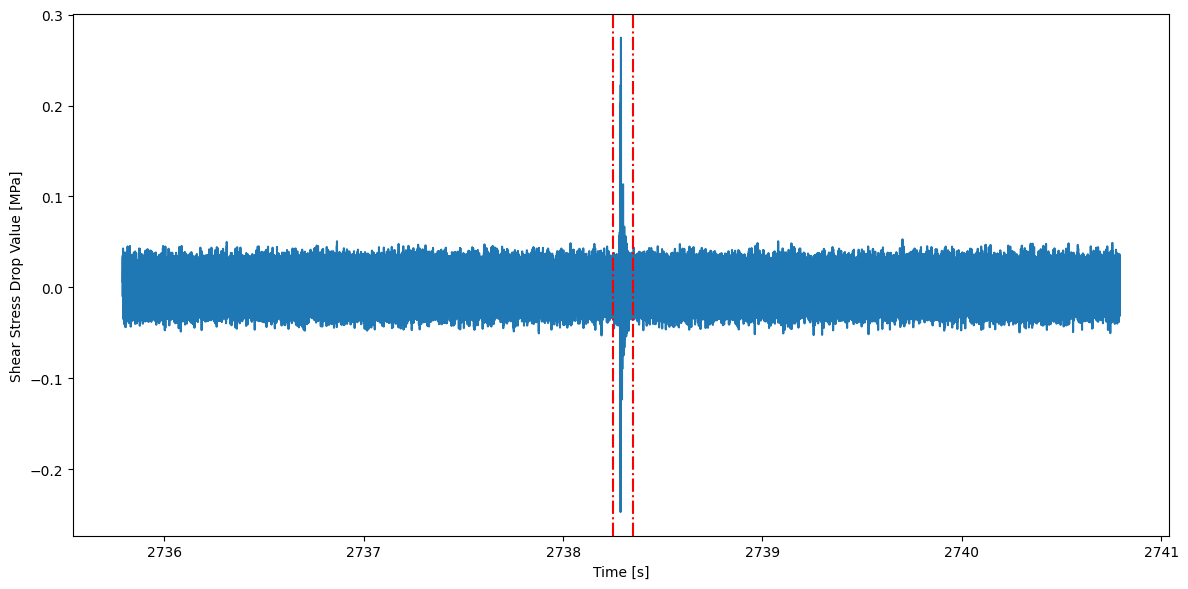

In [8]:
plt.figure(figsize = (12, 6))

plt.plot(TIME_S, FILTERED_STRESS_MPA, label=r'$\epsilon_{xy}$')
plt.xlabel('Time [s]')
plt.ylabel('Shear Stress Drop Value [MPa]')
plt.axvline(x = 2738.25, color = 'red', linestyle = '-.')
plt.axvline(x = 2738.35, color = 'red', linestyle = '-.')
plt.tight_layout()
plt.savefig(f'../Plot/STA-LTA-demo-2.pdf', dpi = 300)
plt.show()
plt.close()

In [9]:
hspan = 2000


# STA, LTA window length
sta_window = 40   # STA window length
lta_window = 300  # LTA window length

# Calculate STA, LTA by convolution
sta = np.convolve(FILTERED_STRESS_MPA**2, np.ones(sta_window)/sta_window, mode='valid')
lta = np.convolve(FILTERED_STRESS_MPA**2, np.ones(lta_window)/lta_window, mode='valid')

# Matching STA and LTA data length
min_length = min(len(sta), len(lta))
sta = sta[:min_length]
lta = lta[:min_length]

# Calculate LTA/STA ratio
lta_sta_ratio = sta / lta

# Find peak and peak's index
max_ratio = np.max(lta_sta_ratio)
max_index = np.argmax(lta_sta_ratio)

In [10]:
DISTANCE = DISTANCE - DISTANCE[max_index]
# STRESS_MPA = STRESS_MPA - np.average(STRESS_MPA[max_index - hspan: max_index - hspan + 1000])

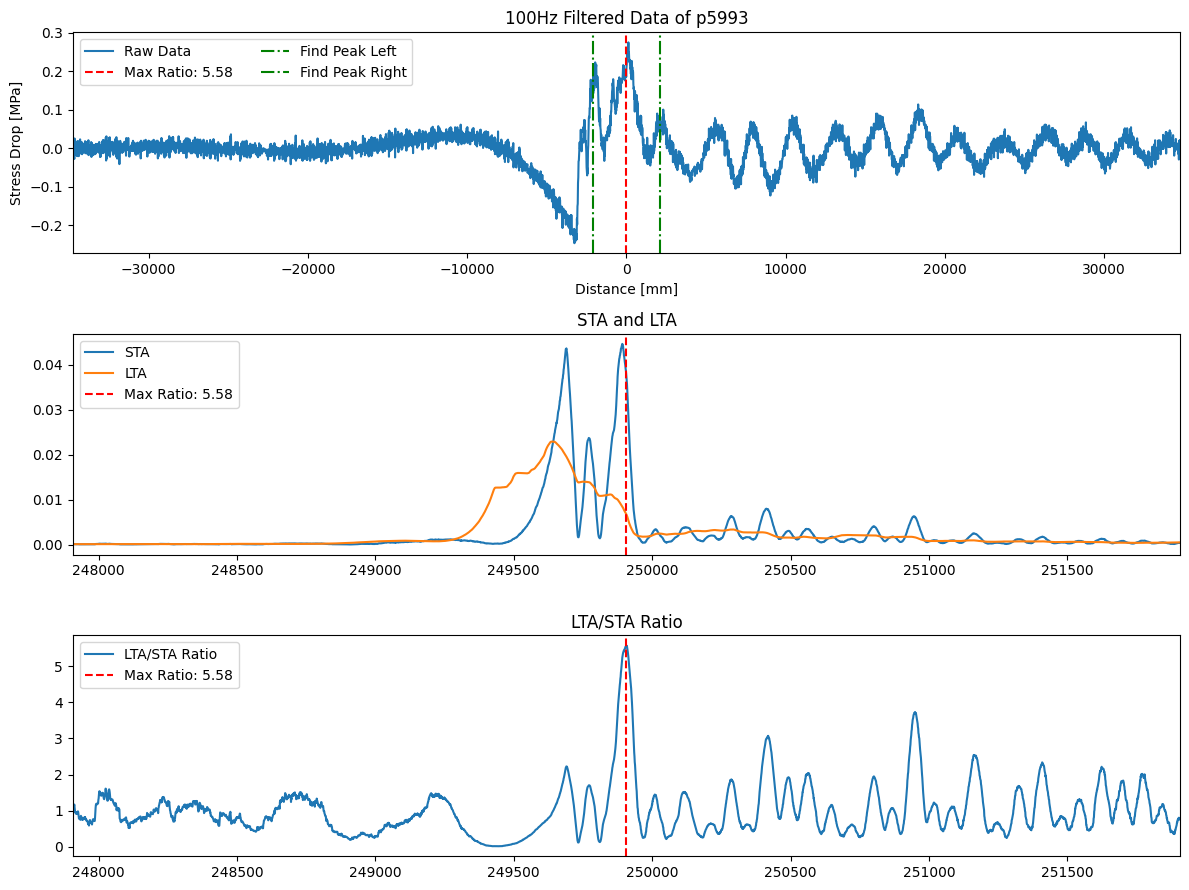

In [11]:
plt.rcParams.update({'mathtext.default':  'regular' })
plt.figure(figsize = (12, 9))

# Plot raw data (No filter)
plt.subplot(3, 1, 1)
plt.plot(DISTANCE, FILTERED_STRESS_MPA, label = 'Raw Data')
plt.xlabel('Distance [mm]')
plt.ylabel('Stress Drop [MPa]')
plt.axvline(x = DISTANCE[max_index], color = 'red', linestyle = '--', label=f'Max Ratio: {max_ratio:.2f}')
plt.axvline(x = DISTANCE[max_index - 120], color = 'green', linestyle = '-.', label = f'Find Peak Left')
plt.axvline(x = DISTANCE[max_index + 120], color = 'green', linestyle = '-.', label = f'Find Peak Right')
plt.xlim(DISTANCE[max_index - hspan], DISTANCE[max_index + hspan])
plt.title(f'100Hz Filtered Data of {experiment_SN}')
plt.legend(ncol = 2, loc = 'upper left')

# Plot STA, LTA
plt.subplot(3, 1, 2)
plt.plot(sta, label = 'STA')
plt.plot(lta, label = 'LTA')
plt.axvline(x = max_index, color = 'red', linestyle = '--', label=f'Max Ratio: {max_ratio:.2f}')
plt.xlim(max_index - hspan, max_index + hspan)
plt.title('STA and LTA')
plt.legend(loc = 'upper left')

# Plot LTA/STA ratio
plt.subplot(3, 1, 3)
plt.plot(lta_sta_ratio, label='LTA/STA Ratio')
plt.axvline(x = max_index, color = 'red', linestyle = '--', label=f'Max Ratio: {max_ratio:.2f}')
plt.xlim(max_index - hspan, max_index + hspan)
plt.title('LTA/STA Ratio')
plt.legend(loc = 'upper left')

plt.tight_layout()
plt.savefig(f'../Plot/STA-LTA-demo-3.pdf')
plt.show()
plt.close()